In [2]:
import decode_eeg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [55]:
def calc_outcome(row):
    """
    calculate outcome of trial 
        hit: notice a change
        miss: fail to notice a change
        rej: notice there is no change
        fa (false alarm): notice change when there isn't one
    """
    accuracy = row['ACC']
    change = row['TrialType']
    if change == 1:
        if accuracy == 1:
            trial_outcome = 'hit'
        else:
            trial_outcome = 'miss'

    if change == 0:
        if accuracy == 1:
            trial_outcome = 'rej'
        else: 
            trial_outcome = 'fa'
    return trial_outcome


def group_behavior(beh):
    for iexp,exp in enumerate(beh.keys()):
        if iexp == 0:
            exp_beh = pd.DataFrame.from_dict(beh[exp])
        else:
            exp_beh = exp_beh.append(pd.DataFrame.from_dict(beh[exp]))
    return exp_beh

def _calc_k(outcome, change):
    """
    a simpler function that returns k
    """
    
    hits = sum(outcome == 'hit')
    fa = sum(outcome == 'fa')

    num_change = sum(change==1)
    num_no_change = sum(change==0)

    h = hits/num_change
    f = fa/num_no_change
    k = 4*(h-f)
    return k

def calc_k(beh):
    beh = group_behavior(beh)
    beh = beh[beh['SetSize']==4]
    beh['outcome']=beh.apply(lambda row : calc_outcome(row), axis = 1)
    k = _calc_k(beh['outcome'],beh['TrialType'])
    return k

In [3]:
experiment_name1 = '1801'
experiment_name2 = '1901'
experiment_name3 = '1902'
data_dir1 = f'./data/{experiment_name1}'
data_dir2 = f'./data/{experiment_name2}'
data_dir3 = f'./data/{experiment_name3}'

exp1 = decode_eeg.Experiment(experiment_name1,data_dir1)
exp2 = decode_eeg.Experiment(experiment_name2,data_dir2)
exp3 = decode_eeg.Experiment(experiment_name3,data_dir3)

In [6]:
time_window = 50
time_step = 25
trial_average = 20
n_splits = 10

group_dict = {0:[1],1:[2],2:[3],3:[4]}
wrangl = decode_eeg.Wrangler(exp1.info['times'],time_window,time_step,trial_average,n_splits,group_dict=group_dict)

sync = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2,exp3],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1,experiment_name2,experiment_name3],
                                    get_matched_data = False)

clfr = decode_eeg.Classification(wrangl,sync.nsub)

In [29]:
k = np.empty(sync.nsub)

for isub,sub in enumerate(sync.all_ids):
    
    beh = sync.load_behavior(sub)
    k[isub] = calc_k(beh)

    xdata,ydata  = sync.load_eeg(sub)
    xdata,ydata = sync.setup_data(xdata,ydata)
    xdata,ydata = sync.group_data(xdata,ydata)

    for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
        y_test_shuffle = np.random.permutation(y_test)
        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

In [30]:
interp = decode_eeg.Interpreter(clfr, subtitle = f'all_unique_subs_{trial_average}_')
# interp.save_results()
# interp.load_results()

In [49]:
from scipy.stats import linregress

def regression_line(slope: float, intercept: float):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

def plot_corr(x: list, y: list, plot_title = None, x_variable_name = 'X Variable', y_variable_name = 'Y Variable', stats_title=True):
    """Plot correlation between two variables of equal length"""

    # Use scipy.stats.linregress to calc correlation
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    stats = {'slope':slope, 'intercept':intercept, 'r_value':r_value, 'p_value':p_value, 'std_err':std_err}

    # Plotting variables
    ax = plt.subplot(111)
    ax.scatter(x,y,alpha=.75)
    
    # Plotting regression line
    regression_line(slope,intercept)

    # Plot labelling
    r_value_round = round(r_value**2,4)
    p_value_round = round(p_value,4)
    if stats_title:
        subtitle_string = f'\nR-sq = {r_value_round}, p = {p_value_round}'
    else:
        subtitle_string = ""
    if plot_title:
        full_title = (plot_title + subtitle_string)
        plt.title(full_title,fontsize=14)
    else:
        plt.title(subtitle_string)
    plt.xlabel(x_variable_name, fontsize=14)
    plt.ylabel(y_variable_name, fontsize=14)

    # Various plot beautification
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)

    plt.show()
    
    return stats

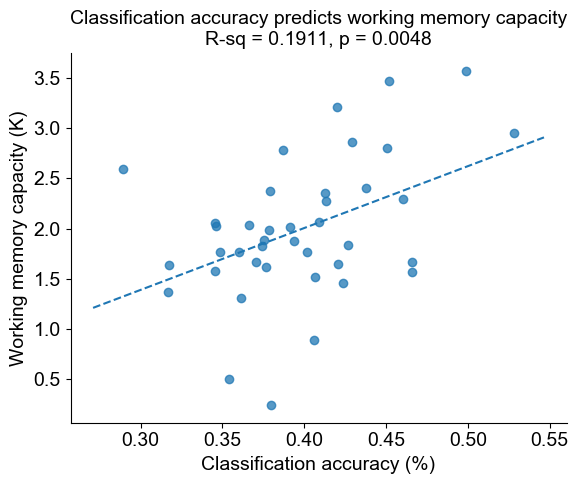

In [59]:
accs = np.mean(np.mean(interp.acc[:,clfr.t>0],2),1).T
plot_corr(list(accs),list(k),plot_title='Classification accuracy predicts working memory capacity',x_variable_name='Classification accuracy (%)',y_variable_name='Working memory capacity (K)')
plt.savefig('classification_acc_k_corr.png',dpi=1000)